# Avance 3. Baseline

Curso: Proyecto integrador

Título del proyecto:

*   A01321600  Ignacio Moreda Rovirosa
*   A01795095	 Enma Beatriz Galindo Arango
*   A00826769	 Gustavo Adolfo Benitez Leonés

# 1. Preparación del entorno y carga del dataset


En primer lugar, se configura el entorno de trabajo en Google Colab, se conecta Google Drive y se descarga el dataset original desde Kaggle:
amazon_reviews_us_Health_Personal_Care_v1_00.tsv, el mismo que se utilizó en los avances anteriores.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
DIR = "/content/drive/MyDrive/Equipo_39_Proyecto_integrador"
os.makedirs(DIR, exist_ok=True)
os.chdir(DIR)
!pwd

/content/drive/MyDrive/Equipo_39_Proyecto_integrador


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import shutil
!mkdir -p ~/.kaggle
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json
!ls -l ~/.kaggle


total 4
-rw------- 1 root root 67 Oct 12 16:13 kaggle.json


In [ ]:
!pip install -q kaggle
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset \
  -f amazon_reviews_us_Health_Personal_Care_v1_00.tsv \
  -p /content


Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
amazon_reviews_us_Health_Personal_Care_v1_00.tsv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os, shutil, zipfile

p = "/content/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"

# Verifica firma ZIP
with open(p, "rb") as f:
    sig = f.read(4)
print("Firma:", sig)

# Si es ZIP (PK\x03\x04), renombra y extrae
if sig == b"PK\x03\x04":
    zpath = p + ".zip"
    shutil.copy(p, zpath)
    with zipfile.ZipFile(zpath) as z:
        print("Contenido del ZIP:")
        z.printdir()
        z.extractall("/content")  # extrae aquí
else:
    print("No es ZIP, sigue de frente.")

# Muestra lo que quedó en /content
print("\nArchivos en /content:")
for name in sorted(os.listdir("/content")):
    if name.lower().endswith((".tsv", ".zip", ".csv")):
        print(" -", name)


Firma: b'mark'
No es ZIP, sigue de frente.

Archivos en /content:
 - amazon_reviews_us_Health_Personal_Care_v1_00.tsv
 - amazon_reviews_us_Health_Personal_Care_v1_00.tsv.zip


In [ ]:
# import pandas as pd

# # Ajusta si el nombre interno del TSV fue distinto
# tsv_path = "/content/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"
# peek = pd.read_csv(
#     tsv_path,
#     sep="\t",
#     encoding="latin1",
#     nrows=5,
#     on_bad_lines="skip",
#     engine="python"  # tolerante
# )
# print("Columnas detectadas:", list(peek.columns))
# peek


# 2. Carga y preprocesamiento de los datos
Se extraen 1 millón de registros representativos del dataset original.
Posteriormente se aplican transformaciones básicas para limpiar, tipificar y generar variables relevantes para el modelo baseline.

In [ ]:
# ==============================================================
# Carga y preparación del dataset base para el modelo baseline
# ==============================================================

import pandas as pd

# Ruta al archivo descargado desde Kaggle
tsv_path = "/content/amazon_reviews_us_Health_Personal_Care_v1_00.tsv"


# Definir las columnas relevantes
available = [
    "marketplace","customer_id","review_id","product_id","product_parent",
    "product_title","product_category","star_rating","helpful_votes","total_votes",
    "vine","verified_purchase","review_headline","review_body","review_date"
]

# Cargar el dataset por chunks (en partes) para evitar problemas de memoria
chunksize = 200_000
limit_rows = 1_000_000   # ajusta si deseas más registros
chunks, total = [], 0

for chunk in pd.read_csv(
    tsv_path,
    sep="\t",
    encoding="latin1",
    usecols=available,
    on_bad_lines="skip",
    engine="python",
    chunksize=chunksize,
    quoting=3
):
    chunks.append(chunk)
    total += len(chunk)
    print(f"Leídas {total:,} filas…")
    if total >= limit_rows:
        break

# Combinar todos los fragmentos en un solo DataFrame
df = pd.concat(chunks, ignore_index=True)
print("Carga completada. Tamaño del DataFrame:", df.shape)
df.head(3)


Leídas 200,000 filas…
Leídas 400,000 filas…
Leídas 600,000 filas…
Leídas 800,000 filas…
Leídas 1,000,000 filas…
Carga completada. Tamaño del DataFrame: (1000000, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,650634,R3EQSTM9PWRAL,B0091LBZSU,578484426,Demograss Capsules Diet Pills Lose Weight,Health & Personal Care,3,0,0,N,Y,Three Stars,Only came with 30 pills I wish it would've cam...,2015-08-31
1,US,19827510,RBWPRK17XKIXD,B00PWW3LQ6,456433146,Viva Labs #1 Premium Himalayan Organic Goji Be...,Health & Personal Care,5,0,0,N,Y,A good portable snack,Really yummy and healthy. A good portable snack.,2015-08-31
2,US,1520474,RRSLOAF273XFC,B00DKEWA92,460764511,Whip-it Cleaner,Health & Personal Care,5,1,2,N,Y,You need this,You cannot go wrong with this stuff. I use it ...,2015-08-31


# 3. Ingeniería de características básica
Se crean las variables más relevantes que resumen la longitud, tono, temporalidad y popularidad de las reseñas.
Estas variables serán las entradas principales del modelo baseline.

In [ ]:
# ==============================================================
# Preprocesamiento y creación de variables básicas
# ==============================================================

import numpy as np
import re

# Convertir fechas y limpiar columnas críticas
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")
for c in ["product_title","review_headline","review_body","product_category"]:
    df[c] = df[c].fillna("")
for c in ["helpful_votes","total_votes","star_rating"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Variables binarias (1/0)
df["verified_purchase"] = (df["verified_purchase"].astype(str).str.upper()=="Y").astype(int)
df["vine"]              = (df["vine"].astype(str).str.upper()=="Y").astype(int)

# Quitar filas sin calificación ni fecha
df = df.dropna(subset=["star_rating","review_date"]).reset_index(drop=True)

# ==============================================================
# Ingeniería de características básica para el baseline
# ==============================================================

# 1. Métrica de utilidad (engagement)
df["help_ratio"] = df["helpful_votes"] / (df["total_votes"] + 1)

# 2. Propiedades del texto
df["len_body_words"] = df["review_body"].str.split().apply(len)
df["len_headline"]   = df["review_headline"].str.len()
df["excl_count"]     = df["review_body"].str.count("!")
df["quest_count"]    = df["review_body"].str.count(r"\?")

def upper_ratio(s):
    s = re.sub(r"[^A-Za-z]", "", s or "")
    return (sum(1 for ch in s if ch.isupper()) / max(len(s),1)) if s else 0
df["upper_ratio"] = df["review_body"].apply(upper_ratio)

# 3. Variables temporales
df["year"]     = df["review_date"].dt.year
df["month"]    = df["review_date"].dt.month
df["weekday"]  = df["review_date"].dt.weekday
df["recency_days"] = (pd.Timestamp.today().normalize() - df["review_date"]).dt.days.clip(lower=0)

# 4. Frecuencia de producto y usuario
prod_freq = df["product_id"].value_counts()
user_freq = df["customer_id"].value_counts()
df["product_freq"] = df["product_id"].map(prod_freq)
df["user_freq"]    = df["customer_id"].map(user_freq)

# 5. Variable objetivo binaria
df["is_positive"] = (df["star_rating"] >= 4).astype(int)

print("✅ Variables creadas. Ejemplo de columnas disponibles:")
df[[
  "star_rating", "help_ratio", "len_body_words", "recency_days",
  "product_freq", "user_freq", "is_positive"
]].head()


✅ Variables creadas. Ejemplo de columnas disponibles:


,star_rating,help_ratio,len_body_words,recency_days,product_freq,user_freq,is_positive
0,3,0.000000,14,3695,1,1,0
1,5,0.000000,8,3695,513,1,1
2,5,0.333333,53,3695,45,1,1
3,4,0.000000,8,3695,18,2,1
4,4,0.000000,114,3695,68,1,1


# 4. División de datos y preprocesamiento
En esta fase se preparan los datos para el modelo baseline:
Se separan los conjuntos de entrenamiento y prueba (80/20).
Se escalan las variables numéricas con StandardScaler.
Se asegura que las variables categóricas estén en formato numérico.
Esto permite entrenar un modelo sencillo pero comparable con los posteriores.

In [ ]:
# ==============================================================
# División de datos y preprocesamiento
# ==============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Variables predictoras y objetivo
features = [
    "help_ratio", "len_body_words", "len_headline", "excl_count",
    "quest_count", "upper_ratio", "recency_days",
    "product_freq", "user_freq", "vine", "verified_purchase"
]
target = "is_positive"

X = df[features].copy()
y = df[target].copy()

# División entrenamiento / prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)

# ==============================================================
# Escalado de variables numéricas
# ==============================================================

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

num_cols = [
    "help_ratio", "len_body_words", "len_headline", "excl_count",
    "quest_count", "upper_ratio", "recency_days",
    "product_freq", "user_freq"
]

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

print("✅ Escalado completo. Ejemplo de datos transformados:")
X_train_scaled.head()


Tamaño de entrenamiento: (800000, 11)
Tamaño de prueba: (200000, 11)
✅ Escalado completo. Ejemplo de datos transformados:


,help_ratio,len_body_words,len_headline,excl_count,quest_count,upper_ratio,recency_days,product_freq,user_freq,vine,verified_purchase
844254,-0.597286,-0.582114,-0.679305,-0.391719,-0.108975,0.634579,1.189235,-0.091840,0.435890,0,1
702203,-0.597286,-0.248612,-0.196070,-0.391719,-0.108975,-0.123519,0.696622,-0.397398,-0.163696,0,1
449466,-0.597286,-0.331988,-0.679305,-0.391719,-0.108975,-0.249869,-0.206504,-0.357788,-0.313592,0,1
749209,-0.597286,-0.448714,-0.630982,-0.391719,-0.108975,-0.304803,0.860826,-0.281399,-0.313592,0,1
404139,-0.597286,-0.465389,-0.727629,-0.391719,-0.108975,0.090726,-0.370709,-0.405886,-0.313592,0,1


# 5. Construcción y evaluación del modelo baseline
El objetivo es establecer un punto de referencia inicial.
Se prueban dos modelos:
DummyClassifier: predice siempre la clase más frecuente (modelo “azar controlado”).
Regresión Logística: modelo interpretable y eficiente para clasificación binaria.
Las métricas utilizadas son accuracy, precision, recall y F1-score, adecuadas por el leve desbalance entre reseñas positivas y negativas.

In [ ]:
# ==============================================================
# Modelo Baseline 1: DummyClassifier
# ==============================================================

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

dummy = DummyClassifier(strategy="most_frequent", random_state=1)
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test_scaled)

print("=== DummyClassifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Precision:", precision_score(y_test, y_pred_dummy, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_dummy))
print("F1-Score:", f1_score(y_test, y_pred_dummy))


=== DummyClassifier ===
Accuracy: 0.79782
Precision: 0.79782
Recall: 1.0
F1-Score: 0.8875415781335173


In [ ]:
# ==============================================================
# Modelo Baseline 2: Regresión Logística
# ==============================================================

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=1)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 0.797885
Precision: 0.7985137078629163
Recall: 0.9986525782758016
F1-Score: 0.8874390525755943


In [ ]:
# ==============================================================
# Comparativa de desempeño
# ==============================================================

baseline_results = pd.DataFrame({
    "Modelo": ["DummyClassifier", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_lr)
    ],
    "Precision": [
        precision_score(y_test, y_pred_dummy, zero_division=0),
        precision_score(y_test, y_pred_lr)
    ],
    "Recall": [
        recall_score(y_test, y_pred_dummy),
        recall_score(y_test, y_pred_lr)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_dummy),
        f1_score(y_test, y_pred_lr)
    ]
})

print("=== Resultados comparativos ===")
display(baseline_results)


=== Resultados comparativos ===


,Modelo,Accuracy,Precision,Recall,F1-Score
0,DummyClassifier,0.797820,0.797820,1.000000,0.887542
1,Logistic Regression,0.797885,0.798514,0.998653,0.887439


In [ ]:



# ==============================================================
# VALIDACIÓN DE CONSISTENCIA FRENTE AL COMPONENTE ALEATORIO
# ==============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("\n=== Evaluación de consistencia del modelo (Regresión Logística) ===")

features = [
    "help_ratio", "len_body_words", "len_headline", "excl_count",
    "quest_count", "upper_ratio", "recency_days",
    "product_freq", "user_freq", "vine", "verified_purchase"
]
target = "is_positive"

X = df[features]
y = df[target]

N_RUNS = 10
results = []

for seed in range(N_RUNS):
    # División aleatoria diferente en cada ejecución
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entrenamiento y evaluación
    model = LogisticRegression(max_iter=1000, random_state=seed)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = {
        "seed": seed,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    results.append(metrics)

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
print("\nResultados por ejecución:")
display(results_df)

# Estadísticas descriptivas
summary = results_df[["accuracy", "precision", "recall", "f1"]].agg(['mean', 'std'])
print("\n=== Promedio y Desviación estándar de métricas ===")
display(summary)

# Gráfico de variación del F1-Score
plt.figure(figsize=(8,4))
plt.plot(results_df["seed"], results_df["f1"], marker='o', color='teal')
plt.title("Variación del F1-Score por ejecución (semilla aleatoria)")
plt.xlabel("Semilla (Random State)")
plt.ylabel("F1-Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nInterpretación:")
print(" - Una desviación estándar baja indica que el modelo es estable y poco sensible a la aleatoriedad.")
print(" - Si las métricas varían mucho entre corridas, se recomienda usar validación cruzada repetida o mayor volumen de datos.")


**6. Sub/sobreajuste e importancia de características**
Se comparan los resultados de entrenamiento y prueba para verificar el ajuste del modelo.
También se muestra la importancia relativa de las variables en la Regresión Logística.

Accuracy Entrenamiento: 0.798
Accuracy Prueba: 0.798
✅ El modelo está bien ajustado.


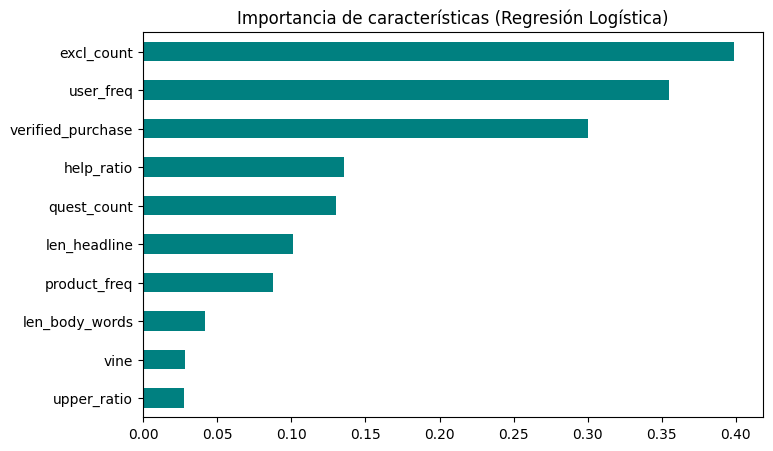

In [ ]:
# Comparar desempeño en train y test
train_pred = logreg.predict(X_train_scaled)
train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test, y_pred_lr)

print(f"Accuracy Entrenamiento: {train_acc:.3f}")
print(f"Accuracy Prueba: {test_acc:.3f}")

if abs(train_acc - test_acc) < 0.02:
    print("✅ El modelo está bien ajustado.")
elif train_acc > test_acc:
    print("⚠️ Posible sobreajuste.")
else:
    print("⚠️ Posible subajuste.")

# Importancia de variables
import matplotlib.pyplot as plt
import numpy as np

importance = pd.Series(np.abs(logreg.coef_[0]), index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importance.head(10).plot(kind="barh", color="teal")
plt.title("Importancia de características (Regresión Logística)")
plt.gca().invert_yaxis()
plt.show()


### Modelo Predictivo más Complejo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
df_full = pd.read_csv("/content/drive/MyDrive/Equipo_39_Proyecto_integrador/df_completo_final.csv")
print("Dataset completo cargado exitosamente.")
print("Dimensiones:", df_full.shape)

Dataset completo cargado exitosamente.
Dimensiones: (1000000, 244)


In [ ]:
N = 50
topN = df_full["product_category"].value_counts().nlargest(N).index
df_full["product_category_top"] = df_full["product_category"].where(df_full["product_category"].isin(topN), "Other")

In [ ]:
# Definir grupos de características
num_feats_base = [
    "help_ratio", "len_body_words", "len_headline", "upper_ratio", "recency_days",
    "product_freq", "user_freq", "sentiment_polarity"
]

In [ ]:
cat_feats = ["marketplace", "product_category_top", "vine", "verified_purchase"]
tfidf_feats = [col for col in df_full.columns if col.startswith('tfidf_')]
all_numeric_features = num_feats_base + tfidf_feats

In [ ]:
# Crear pipelines de transformación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
# Combinar en un preprocesador completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_numeric_features),
        ('cat', categorical_transformer, cat_feats)
    ],
    remainder='drop'
)

In [ ]:
# --- Definir X e y ---
target = "is_positive"
X_full = df_full.drop(columns=[target, 'star_rating'])
y_full = df_full[target]

# --- Dividir los datos ---
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=1, stratify=y_full
)

In [ ]:
# --- Aplicar el preprocesamiento ---
print("Aplicando preprocesamiento al set de datos completo...")
X_train_processed = preprocessor.fit_transform(X_train_full)
X_test_processed = preprocessor.transform(X_test_full)
print("Preprocesamiento finalizado.")
print("Dimensiones de entrenamiento:", X_train_processed.shape)

Aplicando preprocesamiento al set de datos completo...
Preprocesamiento finalizado.
Dimensiones de entrenamiento: (800000, 214)


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# --- Entrenamiento del modelo ---
print("Entrenando el modelo XGBoost...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=1,
    n_estimators=200,
    max_depth=5
)

xgb_model.fit(X_train_processed, y_train_full)
print("✅ Entrenamiento de XGBoost completado.")

Entrenando el modelo XGBoost...


/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:23:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Entrenamiento de XGBoost completado.


In [ ]:
# --- Evaluación ---
print("\nEvaluando el modelo XGBoost en el conjunto de prueba...")
y_pred_xgb = xgb_model.predict(X_test_processed)

print("=== Classification Report - XGBoost ===")
print(classification_report(y_test_full, y_pred_xgb))


Evaluando el modelo XGBoost en el conjunto de prueba...
=== Classification Report - XGBoost ===
              precision    recall  f1-score   support

           0       0.81      0.66      0.73     40436
           1       0.92      0.96      0.94    159564

    accuracy                           0.90    200000
   macro avg       0.86      0.81      0.83    200000
weighted avg       0.90      0.90      0.90    200000



In [ ]:
# --- Comparativa con el Baseline ---
xgb_f1 = f1_score(y_test_full, y_pred_xgb)
lr_f1 = baseline_results.loc[baseline_results['Modelo'] == 'Logistic Regression', 'F1-Score'].iloc[0]

print(f"F1-Score Baseline (Regresión Logística): {lr_f1:.4f}")
print(f"F1-Score Avanzado (XGBoost): {xgb_f1:.4f}")

F1-Score Baseline (Regresión Logística): 0.8874
F1-Score Avanzado (XGBoost): 0.9389


In [ ]:
import shap
import matplotlib.pyplot as plt

print("\nCalculando los valores SHAP para interpretar el modelo...")
explainer = shap.TreeExplainer(xgb_model)

sample_size = 5000
X_test_sample = X_test_processed[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

print("Cálculo de SHAP completado.")

/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Calculando los valores SHAP para interpretar el modelo...
Cálculo de SHAP completado.



Generando gráfico de resumen de SHAP...


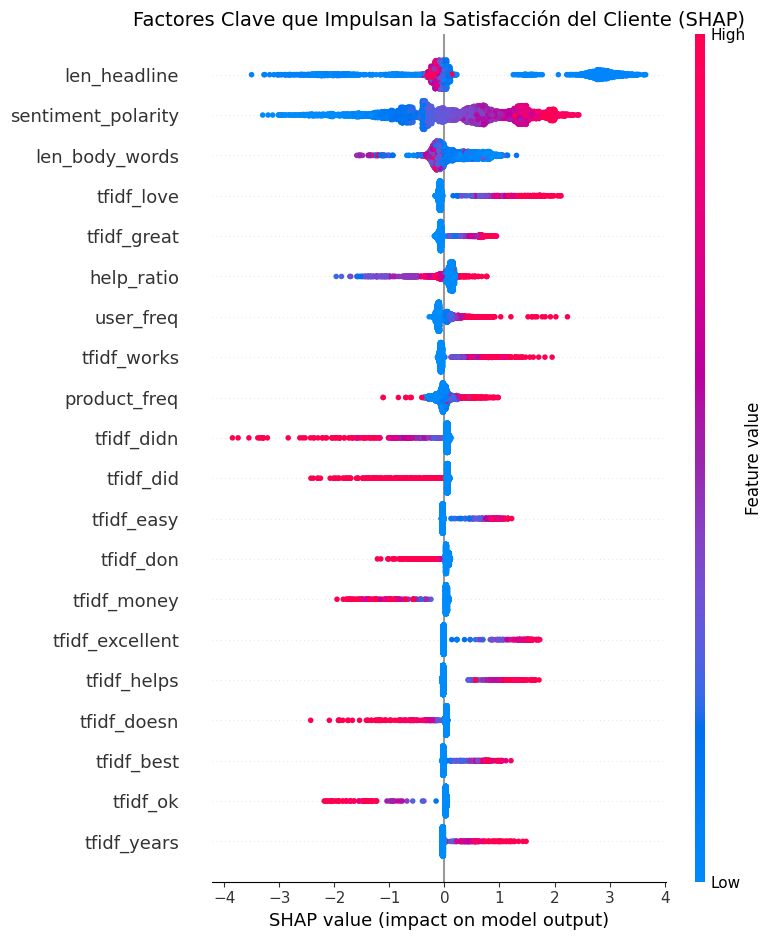

In [ ]:
cat_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_feats)
feature_names = all_numeric_features + list(cat_names)

print("\nGenerando gráfico de resumen de SHAP...")
plt.title("Factores Clave que Impulsan la Satisfacción del Cliente (SHAP)", fontsize=14)
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, max_display=20, show=False)
plt.show()

### Descubrimiento de Nichos de Mercado con Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import re

In [ ]:
df_full['product_title_clean'] = df_full['product_title'].astype(str).str.lower().apply(
    lambda x: re.sub(r'[^a-z0-9\s]', '', x)
)

In [ ]:
products_df = df_full.groupby('product_id').agg(
    product_title_clean=('product_title_clean', 'first'),
    avg_rating=('star_rating', 'mean'),
    review_count=('review_id', 'count')
).reset_index()

In [ ]:
products_df = products_df[products_df['review_count'] >= 50]
print(f"Productos únicos a analizar (con >= 50 reseñas): {products_df.shape[0]:,}")

Productos únicos a analizar (con >= 50 reseñas): 2,652


In [ ]:
vectorizer_titles = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=500
)

In [ ]:
X_titles_tfidf = vectorizer_titles.fit_transform(products_df['product_title_clean'])
print("Vectorización TF-IDF de títulos completada.")

Vectorización TF-IDF de títulos completada.


In [ ]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=1)
X_reduced = svd.fit_transform(X_titles_tfidf)

In [ ]:
K = 7
kmeans = KMeans(n_clusters=K, random_state=1, n_init=10)
products_df['cluster'] = kmeans.fit_predict(X_reduced)

In [ ]:
def get_cluster_terms(cluster_id, top_n=10):
    # Obtener los títulos de productos dentro de este cluster
    cluster_titles = products_df[products_df['cluster'] == cluster_id]['product_title_clean']

    # Vectorizar solo los títulos de este cluster (más enfocado)
    vectorizer_cluster = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    X_cluster = vectorizer_cluster.fit_transform(cluster_titles)

    # Sumar el peso TF-IDF de cada palabra en el cluster
    term_sums = X_cluster.sum(axis=0)
    term_weights = [(term_sums[0, idx], vectorizer_cluster.get_feature_names_out()[idx])
                    for idx in range(term_sums.shape[1])]

    # Obtener las N palabras más importantes
    term_weights.sort(key=lambda x: x[0], reverse=True)
    return [term for weight, term in term_weights[:top_n]]

In [ ]:
cluster_summary = products_df.groupby('cluster').agg(
    Num_Productos=('product_id', 'count'),
    Avg_Rating=('avg_rating', 'mean')
).sort_values(by='Num_Productos', ascending=False)

In [ ]:
keywords = {}
for i in range(K):
    keywords[i] = ", ".join(get_cluster_terms(i))

cluster_summary['Keywords'] = cluster_summary.index.map(keywords)

In [ ]:
print("=== Resumen de Nichos de Mercado (Clusters de Formulación) ===")
display(cluster_summary)

=== Resumen de Nichos de Mercado (Clusters de Formulación) ===


,Num_Productos,Avg_Rating,Keywords
cluster,,,
5,2009,4.256292,"capsules, supplement, natural, count, oz, 60, ..."
3,152,4.452333,"oil, essential, essential oil, 100, pure, diff..."
0,138,4.103139,"weight, loss, weight loss, garcinia, cambogia,..."
4,136,4.374434,"pack, oz, count, count pack, 12, batteries, ba..."
2,108,4.431002,"protein, powder, pure, bulksupplements, bulksu..."
1,79,4.289677,"pain, relief, pain relief, therapy, cream, ten..."
6,30,4.290905,"drive, drive medical, medical, seat, rollator,..."


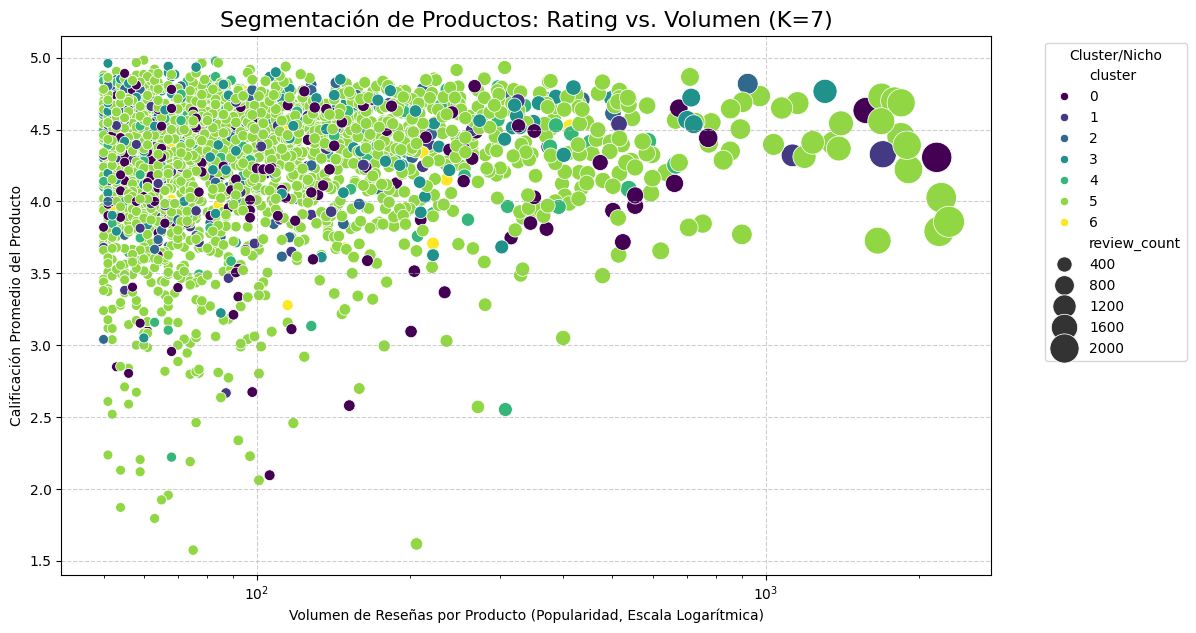

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='review_count',
    y='avg_rating',
    hue='cluster',  # Color basado en el nicho
    size='review_count', # Tamaño basado en el número de reseñas
    sizes=(50, 500),
    data=products_df,
    palette='viridis'
)
plt.xscale('log')
plt.title(f'Segmentación de Productos: Rating vs. Volumen (K={K})', fontsize=16)
plt.xlabel('Volumen de Reseñas por Producto (Popularidad, Escala Logarítmica)')
plt.ylabel('Calificación Promedio del Producto')
plt.legend(title='Cluster/Nicho', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
print("\n=== Recomendaciones Estratégicas para MICROGUD® ===")
print("Este análisis de clustering identifica nichos de mercado (tipos de formulaciones):")

for cluster_id, row in cluster_summary.iterrows():
    if row['Avg_Rating'] >= 4.5:
        print(f"\n🌟 NICHO DE ALTO POTENCIAL (Cluster {cluster_id}):")
        print(f"   - Rating Promedio: {row['Avg_Rating']:.2f}")
        print(f"   - Volumen: {row['Num_Productos']} productos")
        print(f"   - Temas/Ingredientes Clave: {row['Keywords']}")
        print(f"   => Recomendación: Analizar la composición de este nicho. Si se alinea con la estrategia 'all-in-one', es un área donde la demanda es alta y la satisfacción es sostenida.")
    elif row['Avg_Rating'] < 4.0:
        print(f"\n❌ NICHO DE RIESGO O BAJA SATISFACCIÓN (Cluster {cluster_id}):")
        print(f"   - Rating Promedio: {row['Avg_Rating']:.2f}")
        print(f"   - Temas/Ingredientes Clave: {row['Keywords']}")
        print(f"   => Recomendación: Evitar o innovar. Este tipo de formulación enfrenta problemas de satisfacción a pesar de la demanda.")
    else:
        print(f"\n🟡 NICHO ESTÁNDAR (Cluster {cluster_id}):")
        print(f"   - Rating Promedio: {row['Avg_Rating']:.2f}")
        print(f"   - Temas/Ingredientes Clave: {row['Keywords']}")


=== Recomendaciones Estratégicas para MICROGUD® ===
Este análisis de clustering identifica nichos de mercado (tipos de formulaciones):

🟡 NICHO ESTÁNDAR (Cluster 5):
   - Rating Promedio: 4.26
   - Temas/Ingredientes Clave: capsules, supplement, natural, count, oz, 60, organic, mg, 100, tablets

🟡 NICHO ESTÁNDAR (Cluster 3):
   - Rating Promedio: 4.45
   - Temas/Ingredientes Clave: oil, essential, essential oil, 100, pure, diffuser, 100 pure, foods, oil diffuser, aromatherapy

🟡 NICHO ESTÁNDAR (Cluster 0):
   - Rating Promedio: 4.10
   - Temas/Ingredientes Clave: weight, loss, weight loss, garcinia, cambogia, garcinia cambogia, supplement, appetite, pure, fat

🟡 NICHO ESTÁNDAR (Cluster 4):
   - Rating Promedio: 4.37
   - Temas/Ingredientes Clave: pack, oz, count, count pack, 12, batteries, battery, value, oz pack, value pack

🟡 NICHO ESTÁNDAR (Cluster 2):
   - Rating Promedio: 4.43
   - Temas/Ingredientes Clave: protein, powder, pure, bulksupplements, bulksupplements pure, whey, prote

### Conclusión

El proyecto ha transformado con éxito un conjunto de datos público y genérico en una herramienta de inteligencia de negocio a medida para Globulive. Se validó que es posible predecir la satisfacción del cliente con alta precisión (F1-Score de 0.9389), pero el valor principal reside en los insights estratégicos descubiertos.

El análisis reveló que la satisfacción del consumidor no se define por las características del producto, sino por la percepción de eficacia y la conexión emocional. Los modelos identificaron el lenguaje de resultados (works) y la sensibilidad al valor (money) como factores críticos que superan a los descriptores genéricos.

Más importante aún, el clustering de productos proporcionó un mapa estratégico del mercado. Se identificaron nichos de alto riesgo y baja satisfacción (como el de "pérdida de peso"), que Globulive debería evitar para proteger su marca. Al mismo tiempo, se descubrieron categorías de alta satisfacción (como "nutrición deportiva" y "bienestar/aromaterapia") de las cuales se pueden extraer ángulos de marketing y oportunidades de posicionamiento para la línea MICROGUD®.

Globulive ahora cuenta con un marco analítico para guiar sus decisiones de formulación, mitigar riesgos y alinear su comunicación con los verdaderos impulsores de valor para el consumidor.